# 8.3 Lab: Decision Trees

## 8.3.3 Bagging and Random Forest 

Demonstrate bagging (bootstrap aggregation) and random forest for the `Boston` data set from the `MASS` package. We will use the `statsmodels` library to load the R `data.frame` into a `pandas.core.frame.DataFrame` object.

We will use the `sklearn.ensemble` namespace and its associated classifers and regressors for [ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html). Emsemble methods combine the predictions of several other models to improve generalizability and robustness. 

Note that bagging is simply a special case of Random Forest where `m = p` so that the same model can be used for both. Both build on the bootstrap concept (see Chapter 5).

Decision trees suffer from *high variance*, in which the results from fitting different data sets from the same population can lead to quite different outcomes. While *low variance* will provide similar results against distinct data sets. 

In bagging, we will fit `B` number of trees and use a majority vote. A large `B` will not lead to overfitting as the changing in error will slow down. 

We can use out-of-bag (OOB) observations, observations not used in the training, to estimate the test error rate without cross-validation or the validation set approach.

Random forests help decorrelate the trees by randomly selecting predictors, `m`, for fitting at each split instead of allowing all the predictors, `p`, to be available. When `m=p`, we are simply using bagging. 

** It is important to note that the default for the parameter `max_features` is `auto` in which for the `RandomForestRegressor` it becomes `max_features = n_features` and for the `RandomForestClassifer` it becomes `max_features = sqrt (n_features)`. Other recommendations for the maximum features for a regressor have set the value to `p / 3`.

### Imports



In [1]:
from typing import List, Dict, Tuple, Sequence, Union
import sys

import statsmodels # root namespace for typing
import statsmodels.api as statsModels # alias to hide the extra api namespace

import numpy
import pandas 

import sklearn
import sklearn.inspection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as pyplot

# custom support functions under libraries
sys.path.insert (0, "../../common-functions")
from DecisionTreeSummary import *

### Data Acquisition

In [2]:
# download the R data set as a pandas DataFrame
bostonDataSet: statsmodels.datasets.utils.Dataset = statsModels.datasets.get_rdataset ("Boston", "MASS")

# print out the help information on the data set to get the column documentation
print (bostonDataSet.__doc__)

+--------+-----------------+
| Boston | R Documentation |
+--------+-----------------+

Housing Values in Suburbs of Boston
-----------------------------------

Description
~~~~~~~~~~~

The ``Boston`` data frame has 506 rows and 14 columns.

Usage
~~~~~

::

   Boston

Format
~~~~~~

This data frame contains the following columns:

``crim``
   per capita crime rate by town.

``zn``
   proportion of residential land zoned for lots over 25,000 sq.ft.

``indus``
   proportion of non-retail business acres per town.

``chas``
   Charles River dummy variable (= 1 if tract bounds river; 0
   otherwise).

``nox``
   nitrogen oxides concentration (parts per 10 million).

``rm``
   average number of rooms per dwelling.

``age``
   proportion of owner-occupied units built prior to 1940.

``dis``
   weighted mean of distances to five Boston employment centres.

``rad``
   index of accessibility to radial highways.

``tax``
   full-value property-tax rate per \\$10,000.

``ptratio``
   pupil-teache

In [3]:
# Get the pandas DataFrame, use copy so that we can re-run from this point 
# and recover the original data set (non-referenced).
bostonDataFrame: pandas.core.frame.DataFrame = bostonDataSet.data.copy ()

# preview the data
bostonDataFrame.head ()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Modeling

Fit a random forest model with `mtry = 13` which indicates that all 13 variables should be considered for each split, so that `m = p = 13` and we are bagging. Then we will use the test data to get the MSE and compare it against the previous lab and fitting the decision tree regressor.

In R, the default values for `mtry` is `p/3` for regression trees and `sqrt(p)` for classification trees.

In Python, the parameter that controls the number of predictors available at a split is `max_features`. The default is `auto` so that `m = p` and you get bagging. We will use `int (p / 3)` for 

**R Code**
```R
library (MASS)
library (randomForest)
set.seed (1)
train = sample (1:nrow (Boston), length (Boston) /2)
bag.boston = randomForest (medv ~ ., data = Boston, subset = train, mtry = 13, importance = TRUE)


# predict and score the test data set 
yhat.bag = predict (bag.boston, newdata = Boston [-train, ])
boston.test = Boston [-train, "medv"]
plot (yhat.bag, boston.test) 
abline (0, 1)
mean ((yhat.bag - boston.test) ^2) 
```

In [4]:
# slice the data frame into the X matrix and the y response vector 
X = bostonDataFrame.iloc [:, 0:-1]  # skip response variable in the last position
y = bostonDataFrame.loc [:, ["medv"]].to_numpy().ravel () # as vector

# set the seed for repeatable results
numpy.random.seed (5) # this seed has results that approximately mirror R results

# use the train test splitter to split randomly into data sets (50% each)
trainX, testX, trainy, testy = sklearn.model_selection.train_test_split (X, y, test_size = 0.50)

# instatiate an instance of the sklearn.ensemble.RandomForestRegressor
randomForestModel = RandomForestRegressor (n_estimators = 500, max_features = 13) # fit all features
randomForestModel = randomForestModel.fit (X = trainX, y = trainy)


In [5]:
# create summary 
print (randomForestModel)
print ("               Type of random forest: " + ("regression" if isinstance (randomForestModel, RandomForestRegressor) else "classification"))
print ("                     Number of trees: {:0d}".format (randomForestModel.n_estimators))
print ("No. of variables tried at each split: {:0d}".format (randomForestModel.max_features))

# calculate MSE and R2 of training set to mirror R output
yhat = randomForestModel.predict (trainX)
mse = sklearn.metrics.mean_squared_error (trainy, yhat)
r2  = sklearn.metrics.r2_score (trainy, yhat) * 100
print ("        Mean of squared residuals: {:.4f}".format (mse))
print ("                  % Var explained: {:.4f}".format (r2))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=13, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 13
        Mean of squared residuals: 2.1839
                  % Var explained: 97.4291


Test MSE: 10.7156


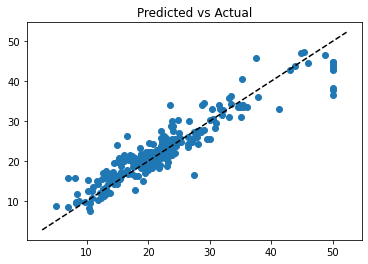

In [6]:
# predict the test set and get the MSE 
yhat = randomForestModel.predict (testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("Test MSE: {:.4f}".format  (mse))

pyplot.scatter (testy, yhat)
axes = pyplot.gca ()
axes.set_title ("Predicted vs Actual")
pyplot.plot (numpy.array (axes.get_xlim ()), numpy.array (axes.get_xlim ()), linestyle = "--", color = "k")

The test MSE with bagging is 10.72 which is much smaller than the 40.53 found in the second lab using a decision tree regressor.

Refitting with smaller set of trees (original was set to 500 to mirror the default in R). In R, we use the `ntree` parameter, and in Python, we use the `n_estimators` parameter.

**R Code**
```R
bag.boston = randomForest (medv ~ ., data = Boston, subset = train, mtry = 13, ntree = 25)
yhat.bag = predict (bag.boston, newdata = Boston [-train, ])
mean ((yhat.bag - boston.text)^2)
```


In [7]:
# instatiate an instance of the sklearn.ensemble.RandomForestRegressor
randomForestModel = RandomForestRegressor (n_estimators = 25, max_features = 13) # fit all features
randomForestModel = randomForestModel.fit (X = trainX, y = trainy)

In [8]:
# create summary 
print (randomForestModel)
print ("               Type of random forest: " + ("regression" if isinstance (randomForestModel, RandomForestRegressor) else "classification"))
print ("                     Number of trees: {:0d}".format (randomForestModel.n_estimators))
print ("No. of variables tried at each split: {:0d}".format (randomForestModel.max_features))

# calculate MSE and R2 of training set to mirror R output
yhat = randomForestModel.predict (trainX)
mse = sklearn.metrics.mean_squared_error (trainy, yhat)
r2  = sklearn.metrics.r2_score (trainy, yhat) * 100
print ("        Mean of squared residuals: {:.4f}".format (mse))
print ("                  % Var explained: {:.4f}".format (r2))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=13, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
               Type of random forest: regression
                     Number of trees: 25
No. of variables tried at each split: 13
        Mean of squared residuals: 3.2280
                  % Var explained: 96.2000


Test MSE: 11.5663


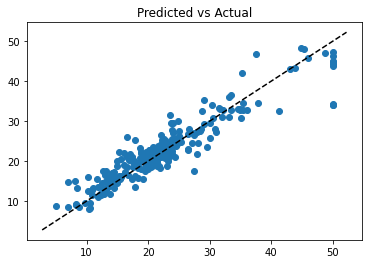

In [9]:
# predict the test set and get the MSE 
yhat = randomForestModel.predict (testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("Test MSE: {:.4f}".format  (mse))

pyplot.scatter (testy, yhat)
axes = pyplot.gca ()
axes.set_title ("Predicted vs Actual")
ignore = pyplot.plot (numpy.array (axes.get_xlim ()), numpy.array (axes.get_xlim ()), linestyle = "--", color = "k")


Both examples above are examples of bagging since `m = p = 13`. In the following example, we will limit the number of predictors available to the algorithm to choose from at each split. For classification, the recommendation is sqrt (p), and for regression, the recommendation is p/3.  

**R Code**
```R
# keeping the 25 maximum trees as any more was causing problems with the %IncMSE
set.seed(1)
rf.boston = randomForest (medv ~ ., data = Boston, subset = train, mtry = 6, ntree = 25, importance = TRUE)
yhat.rf = predict (rf.boston, newdata = Boston [-train, ])
plot (yhat.bag, boston.test) 
abline (0, 1)
mean ((yhat.rf - boston.test)^2)
```

In [10]:
# reuse the same training/test split, set the maximum features to p/3
maximumFeatures: int = int (len  (trainX.columns) / 3)

# let's override this with the book example of 6, but I'm leaving the above 
# in place as an example of getting the maximum features based on tha recommendation
maximumFeatures = 6

# instatiate an instance of the sklearn.ensemble.RandomForestRegressor
randomForestModel = RandomForestRegressor (max_features = maximumFeatures) 
randomForestModel = randomForestModel.fit (X = trainX, y = trainy)

In [11]:
# create summary 
print (randomForestModel)
print ("               Type of random forest: " + ("regression" if isinstance (randomForestModel, RandomForestRegressor) else "classification"))
print ("                     Number of trees: {:0d}".format (randomForestModel.n_estimators))
print ("No. of variables tried at each split: {:0d}".format (randomForestModel.max_features))

# calculate MSE and R2 of training set to mirror R output
yhat = randomForestModel.predict (trainX)
mse = sklearn.metrics.mean_squared_error (trainy, yhat)
r2  = sklearn.metrics.r2_score (trainy, yhat) * 100
print ("        Mean of squared residuals: {:.4f}".format (mse))
print ("                  % Var explained: {:.4f}".format (r2))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 6
        Mean of squared residuals: 2.0289
                  % Var explained: 97.6115


Test MSE: 10.5430


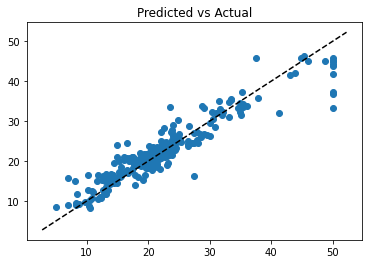

In [12]:
# predict the test set and get the MSE 
yhat = randomForestModel.predict (testX)
mse = sklearn.metrics.mean_squared_error (testy, yhat)
print ("Test MSE: {:.4f}".format  (mse))

pyplot.scatter (testy, yhat)
axes = pyplot.gca ()
axes.set_title ("Predicted vs Actual")
ignore = pyplot.plot (numpy.array (axes.get_xlim ()), numpy.array (axes.get_xlim ()), linestyle = "--", color = "k")

### Feature Importance

In R, we can use the `importance()` function to get relative feature importance from a fitted random forest model. It provides 2 values per variable. The first value `%IncMSE` is the mean decrease of accuracy in predictions (or the mean increase in MSE) on the out-of-bag observations. The second value `IncNodePurity` is the mean over all trees of the total decrease in node impurity that results from splits over that varable (moving from entropy to information).

> Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative. 

> from [Feature importances with forest of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

**R Code**
```R
importance(rf.boston)
varImpPlot(rf.boston)
```

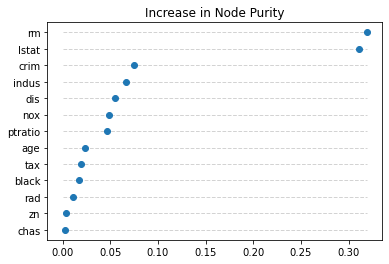

In [13]:
# combine the 2 arrays into a set of tuples of (importance, column-name) and sort
featureImportance = zip (list (randomForestModel.feature_importances_), list (testX.columns))
featureImportance = sorted (featureImportance, reverse=False)
maxImportance = max (randomForestModel.feature_importances_)

# another approach to break out the arrays instead of map could be 
# importances, featureNames = [(list (tuple) for tuple in tuples]

for currentImportance in list (map (lambda current: current[1], featureImportance)):
    pyplot.plot ([0, maxImportance], [currentImportance, currentImportance], linestyle = "--", linewidth = 1, color = "lightgray")

pyplot.scatter (x = list (map (lambda current: current[0], featureImportance)), 
                y = list (map (lambda current: current[1], featureImportance)), zorder=10)

ignore = pyplot.title ("Increase in Node Purity")           

The 2 most important features are: 
* `lstat`: lower status of the population (percent).
* `rm`: average number of rooms per dwelling.

These are by far the 2 most important variables as soon by the large gap in the main group of variables (< 0.10) and these 2 variables (~ > 30).
  

## Permutation Importance 

We will look at permutation importance to compare the impurity-based feature importance with the permutation importance with the test set. The impurity-based feature importance is based solely on the training data set which can cause features to overfit and show a higher predictive importance than is true. The permutation method below can be used both with the training and test set. 

Please see [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

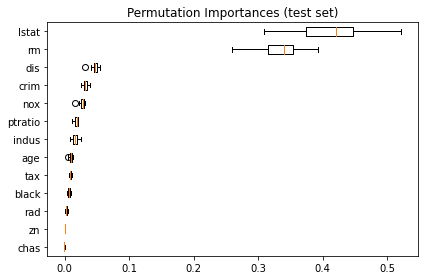

In [14]:
# sklearn.inspection.permutation_importance
permutationImportance = sklearn.inspection.permutation_importance (randomForestModel, testX, testy, n_repeats = 10, n_jobs = 2)

importanceSortedIndex = permutationImportance.importances_mean.argsort ()

figure, axes = pyplot.subplots ()
axes.boxplot (permutationImportance.importances [importanceSortedIndex].T, vert = False, 
            labels = testX.columns [importanceSortedIndex])
axes.set_title ("Permutation Importances (test set)")        
figure.tight_layout()
pyplot.show ()